In [95]:
#I is the Nx1 vector containing the status of each farm
#I=0 Susceptible
#I=1 Exposed
#I=2 Infectious
#I=3 Reported
#I=4 Culled

#s = Nx1 vector containing latent period of each farm 

#r = Nx1 vector containing infectious period of each farm

#A is the Nx6 matrix containing
#column1: Index of the farm
#column2: Day number at which the farm became exposed
#column3: Latent period of the farm
#column4: Infectious period of the farm

#toBeCulled is an Nx2 matrix containing information about farms that need to be Culled
#column1: Index of the farm
#column2: Time that has passed since its infectious period finished
#N.B. By infectious period, this means the time after which it can be culled.
#The farm is still infectious once the infectious period has passed.

#toBeCulledOrdered is the same matrix as above, except the farms have been ordered
#by the length of time they have been waiting to be culled

In [96]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from matplotlib import animation
import time
import pandas as pd
import multiprocessing
import itertools
from scipy.spatial import distance
import networkx as nx
np.set_printoptions(threshold=np.nan)
import os

#os.chdir('/Users/apple/Desktop/group/data');
np.random.seed(5761)
countyNumber = 8
PATH = ''

In [97]:
#Import 2010 Farm Data
farmData=pd.read_csv(PATH+"Farms_2010_RSG",names=["County Number", "Parish Number", "Holding Number", 
                                               "X Coordinate", "Y Coordinate", "Number of Cattle", 
                                               "Number of Sheep"],delim_whitespace=True)
cumbData = farmData[farmData['County Number'] == countyNumber]
# cumbData.locumbData.loc[cumbData['X Coordinate'] == np.max(cumbData['X Coordinate'].values)].index)
#Import 2010 batch size movement data
movBatchSize=pd.read_csv(PATH+"aggmovementdata_2010_2.txt",names=["CTS Off Farm", "CTS On Farm", "CTS Market", 
                                               "Day Number", "Number of Animals Moved"])
movBatchSize = movBatchSize[movBatchSize['CTS On Farm'] != -1]
movBatchSize = movBatchSize[movBatchSize['CTS Off Farm'] != -1]
movBatchSize = movBatchSize[movBatchSize['CTS Market'] == -1]

#Import CTS data file and restrict to countyNumber
ctsKeys=pd.read_csv(PATH+"cts_keys.csv",names=["Off CTS Number", "On CTS Number", "County", "Parish", "Holding"])
cumbCtsKeys = ctsKeys[ctsKeys['County'] == countyNumber]

#Merge CTS dataframe with cumbData according to parish and holding number
pd.options.display.max_rows = 5000
mergeCumbData = cumbData.merge(cumbCtsKeys, left_on=["Parish Number", "Holding Number"], right_on=["Parish", "Holding"], how='left')
mergeCumbData = mergeCumbData.drop(["County", "Parish", "Holding"], axis=1)

Vets = pd.read_csv("Vets_in_cumbria.csv",names=['X Coordinate', 'Y Coordinate'])

xVets = 1.0*Vets['X Coordinate']
yVets = 1.0*Vets['Y Coordinate']
xCumb = 1.0*cumbData['X Coordinate']
yCumb = 1.0*cumbData['Y Coordinate']
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
xcoord = xCumb - xmin #Shift to start from (0, 0)
ycoord = yCumb - ymin #Shift to start from (0, 0)
N=np.size(xcoord)

vetXcoord = xVets-xmin
vetYcoord = yVets - ymin

cattleFrame = cumbData['Number of Cattle']
sheepFrame = cumbData['Number of Sheep']

offCTS = mergeCumbData['Off CTS Number']
onCTS = mergeCumbData['On CTS Number']

numAnimalsMoved = movBatchSize['Number of Animals Moved'].values
lenMovement = len(numAnimalsMoved)


In [98]:
CumbNum=cumbData.index.values+1 # farm number is from 1 to coincide with movement data

In [99]:
# movement data
Movement=pd.read_csv(PATH +'movements_unique', 
                       names = ["From", "To", "Weight"], delim_whitespace=True)
Movement=np.absolute(Movement);

# take movement from CumbNum to CumbNum
CumbMoveInt=Movement[Movement['From'].isin(CumbNum)]
CumbMove=CumbMoveInt[CumbMoveInt['To'].isin(CumbNum)]


CumbMoveFrom=CumbMove['From'].values.astype(int)

CumbMoveTo=CumbMove['To'].values.astype(int)
CumbMoveW=CumbMove['Weight'].values

In [100]:
#Calculate Euclidean distances
xinput = xcoord.values
xinput[2619] = np.mean(xinput)
yinput = ycoord.values
yinput[2619] = np.mean(yinput)
joinedinput = np.column_stack((xinput, yinput))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

In [101]:
plt.plot(xinput, yinput, 'o')

In [102]:
# Time to get from any farm to a vet
xvetput = vetXcoord.values
yvetput = vetYcoord.values
joinedvetput = np.column_stack((xvetput, yvetput))
distVets = distance.cdist(joinedvetput, joinedinput, 'euclidean')
timeVets = (distVets/64373.8)*60 #time in minutes 
timeVets = timeVets+ (-timeVets%5) #time in 5 minute chunks 

In [103]:
timeVets[:,0]

array([65., 55., 55., 55., 65., 45., 10., 10., 45., 50., 20., 50., 25.,
       20., 15., 70., 60.])

In [104]:
#Parameter values     
# psi = 0.00657
# nu = 1.99*(10**(-7))
# xi = 2.65
# zeta = 1.80
# chi = 0.403
nu=5.1e-7
xi=7.7e-7
zeta=10.5
chi=1
s = np.random.negative_binomial(50, 1.0*50/55, N) #Draw latent periods
r = np.random.negative_binomial(30, 1.0*30/39, N) #Draw infectious periods

t = 1
A = np.zeros(shape=(N,4), dtype=np.int64)

a1=0.1 #CumbMoveFrom movement rate reduction when reported
a2=0.1 #CumbMoveTo movement rate reduction when reported
#output = np.zeros(shape=(N,6))

#resourceNum=10 #Number of farms that can be culled each day

# numCattleBanned = 0
# numSheepBanned = 0

# numMovementsBanned = 0

# move=0
# move2=0

cattle = abs(cattleFrame.values)
sheep = abs(sheepFrame.values)

In [105]:
#Calculate distance kernel
# K = psi**2/(psi**4 + dist**4)

# K[np.where(dist > 0.5)] = 0

kernelData=pd.read_csv(PATH + 'Kernel',header=None,delim_whitespace=True)
kernelDist = kernelData.values[:,0]
kernelValue = kernelData.values[:,1]
zeroDistKernel = 1
roundDist = np.rint(dist/100)

K = np.zeros(shape=(N,N))
for i in range(len(roundDist)):
    for j in range(len(roundDist)):
        if (roundDist[i,j] != 0) & (roundDist[i,j] <= 599):
            K[i,j] = kernelValue[int(roundDist[i,j])-1]
        elif roundDist[i,j] > 599:
            K[i,j] = 0
        elif roundDist[i,j] == 0:
            K[i,j] = kernelValue[0]

In [106]:
np.max(roundDist[:,6])

791.0

In [107]:
#Choose initial case

# initial1 = random.randint(0,N)
# initial2=initial1+1
# initial3=initial2+1
# initial4=initial3+1
# # initial2=(initial1+1000)%N
# # initial3=(initial2+2000)%N
# # initial4=(initial3+3000)%N

# I = np.zeros(N, dtype=np.int64)

# I[initial1] = 1
# I[initial2] = 1
# I[initial3] = 1
# I[initial4] = 1

# A[initial1, ] = [initial1, 0, s[initial1], r[initial1]]
# A[initial2, ] = [initial2, 0, s[initial2], r[initial2]]
# A[initial3, ] = [initial3, 0, s[initial3], r[initial3]]
# A[initial4, ] = [initial4, 0, s[initial4], r[initial4]]

In [157]:
# quantities which are useful for limited resource ring cull
culledind=[] 
IP=[]
RC=[]
farmsize_ip1 = []
farmsize_rc1 = []
neighbours_ip1 = []
neighbours_rc1 = []
averageNumberCulled = []
Capacity=40 # capacity for culling

# quantities which are useful for movement count
# count_move=0 #Number of movements that lead to infection

# quantities which are useful for local movement constrain
MoveRange=1.0*5000
# MoveCons=[]

#quantities which are useful for farm-specific local movement constrain
k=(10000-0)/(2*(max(cattle+sheep)-min(cattle+sheep)))
FarmMoveRange=k*(cattle+sheep)
#FarmMoveRange=1.0*100*np.ones(len(cattle))/100000

# quantities which are useful for ring cull
RingCull=1.0*3000
#RingCull=0

# count_move2=0 #Number of movements

#vets availability per day
# vetAvailability = np.zeros(shape = (17, 3))
# vetAvailability[:, 0] = range(17)

In [158]:
# for plot purpose
# reportind = [i for i in range(np.size(I)) if I[i]==3]
# infectind = [i for i in range(np.size(I)) if I[i]==2]
# exposedind = [i for i in range(np.size(I)) if I[i]==1]

# Exp=[len(exposedind)]
# Inf=[len(infectind)]
# Rep=[len(reportind)]

# CullSheep=[0]
# CullCattle=[0]
# time_plot=[0]
livestock = cattle +sheep
timeToKILL = (300/9102)*(livestock-1)+120 #time spent killing a farm should be proportional to farm size
timeToKILL = timeToKILL+ (-timeToKILL%5) #in steps of 5minutes

In [159]:
duration=[]
cullfarmnum=[]
cullsheepnum=[]
cullcattlenum=[]
movecount=[]
LocalFarmBan=[]
LocalNumMoveBan=[]
cattleBanned=[]
sheepBanned=[]
movementsBanned=[]
moveConsDay=[]

In [170]:
cumInfArray = np.zeros(300)
InfArray = np.zeros(300)
for ii in range(50):
    print(ii)
    count_move=0
    culledind=[] 
    IP=[]
    RC=[]
    MoveCons=[]
    MoveConsIndex=[]
    LocalNumMoveBanPerDay=[]
    LocalFarmBanPerDay=[]
    farmsize_ip1 = []
    farmsize_rc1 = []
    neighbours_ip1 = []
    neighbours_rc1 = []
    averageNumberCulled = []
    numCattleBanned = 0
    numSheepBanned = 0
    numMovementsBanned = 0
    timeBanned = 0
    moveInfect = 0
    moveNotInfect = 0
    cumInf = np.zeros(300)
    numInf = np.zeros(300)

    move=0
    move2=0
    count_move2=0
    vetAvailability = np.zeros(shape = (17, 3))
    vetAvailability[:, 0] = range(17)
    
    t = 1
    A = np.zeros(shape=(N,4), dtype=np.int64)
    start_time = time.time()
    
    initial1 = random.randint(0,N)
    initial2=initial1+1
    initial3=initial2+1
    initial4=initial3+1

    I = np.zeros(N, dtype=np.int64)
#     print(I)

    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
    I[initial4] = 1

    A[initial1, ] = [initial1, 0, s[initial1], r[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3]]
    A[initial4, ] = [initial4, 0, s[initial4], r[initial4]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    exposedind = [i for i in range(np.size(I)) if I[i]==1]
    reportind = [i for i in range(np.size(I)) if I[i]==3]
#     print(reportind)
    
    Exp=[len(exposedind)]
    Inf=[len(infectind)]
    Rep=[len(reportind)]
    
    CullSheep=[0]
    CullCattle=[0]
    time_plot=[0]
    
    %matplotlib notebook

#     start_time = time.time()

#     fig = plt.figure()
#     ax = fig.add_subplot(211)
#     ax1 = fig.add_subplot(413)
#     ax2 = fig.add_subplot(414)
#     plt.ion

#     fig.show()
#     fig.canvas.draw()

    while t < 300:
        
        infNum = 0
        
    ###########Only useful for 'infect based on movement - global movement constrain' ############################# 

#        # find the index(from 0) and farm number(from CumbNum[0]) for reported farms
#         INFIndex=[i for i in range(len(I)) if (I[i] == 3)]
#         allFarms = [i for i in range(len(I))]
#         INF=allFarms+CumbNum[0]
#         NI=len(INF)
#         if (len(INFIndex) > 0):
#             MoveCons = INF
#             timeBanned += 1
#         else:
#             MoveCons = []    
#         MoveCons=list(set(MoveCons))
        

    ###########Only useful for 'infect based on movement - local ring movement constrain' ############################# 

#        # find the index(from 0) and farm number(from CumbNum[0]) for reported farms
        INFIndex=[i for i in range(len(I)) if (I[i]==3)]
        INF=INFIndex+CumbNum[0]
        NI=len(INF)

        for i in INFIndex:
            D=np.power(xinput[i]-xinput,2)+np.power(yinput[i]-yinput,2)
            n2=[k for k in range(len(I)) if D[k]<=MoveRange**2]+CumbNum[0]
            MoveCons.extend(n2)
        MoveCons=list(set(MoveCons))
        LocalFarmBanPerDay.append(len(MoveCons))



    ###########Only useful for 'infect based on movement - farm local ring movement constrain' ############################# 

    #find the index(from 0) and farm number(from CumbNum[0]) for infected farms
    #     INFIndex=[i for i in range(len(I)) if (I[i]==3)]
    #     INF=INFIndex+CumbNum[0]
    #     NI=len(INF)

    #     for i in INFIndex:
    #         D=np.power(xinput[i]-xinput,2)+np.power(yinput[i]-yinput,2)
    #         n2=[k for k in range(len(I)) if D[k]<=FarmMoveRange[i]**2]+CumbNum[0]
    #         MoveCons.extend(n2)

    #Calculate transmission rate
#         print(A)
        beta1 = zeta*(cattle)**chi + (sheep)**chi
        beta = np.zeros(N)

        infCattle = cattle[I==2] #Have a different rate of infection for infections from infected animals and reported animals
        repCattle = cattle[I==3]
    #     print('repCattle', repCattle)
        infSheep = sheep[I==2]
        repSheep = sheep[I==3]
    #     print('repSheep', repSheep)

        for j in range(N):
            beta[j] = beta1[j]*(np.sum((xi*(infCattle**chi) + nu*(infSheep**chi))*K[I == 2, j]) + np.sum((xi*(repCattle**chi) + nu*(repSheep**chi))*K[I == 3, j])*0.7)
            #Second part of this is the component of the infection rate due to infectiousness of other farms

    #Calculate probability of infection

        prob_inf = 1 - np.exp(-beta)

    #Infect if probability is less that a uniform sample

        unif = np.random.uniform(0, 1, N)

        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i]]
                #print("Kernel-based","Farm", i, "Day", t)

    ##################################################################################################################
    ##Infect based on movement - No constraint
    ##################################################################################################################

#         rand22 = np.random.uniform(0,1,len(CumbMoveFrom))
#         for i in range(int(len(CumbMoveFrom))):
#             movInd = np.random.randint(0, lenMovement)
#             if (cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]] > 0):
#                 propCattle = cattle[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
#                 propSheep = sheep[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
#             else:
#                 propCattle = 0
#                 propSheep = 0
#             cattleMove = min(round(propCattle*numAnimalsMoved[movInd]), cattle[CumbMoveFrom[i]-CumbNum[0]])
#             sheepMove = min(round(propSheep*numAnimalsMoved[movInd]), sheep[CumbMoveFrom[i]-CumbNum[0]])
#             if (I[CumbMoveFrom[i]-CumbNum[0]] != 4) and  (I[CumbMoveTo[i]-CumbNum[0]] != 4):
#                 if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
#                     if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                         if rand22[i] < a1[0]*a2[0]*CumbMoveW[i]:  
#                             cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]]
#                             cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]]
#                             sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]]
#                             sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]]
#                             move2+=1
#                             if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                 if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                     beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                     beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                     prob_inf2 = 1 - np.exp(-beta12)
#                                     unif2 = np.random.uniform(0, 1)
#                                     if (unif2 <= prob_inf2):
#                                         move+=1
#                                         I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                         A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                     else:
#                         if rand22[i] < a1[0]*CumbMoveW[i]:
#                             cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]]
#                             cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]]
#                             sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]]
#                             sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]]
#                             move2+=1
#                             if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                 if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                     beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                     beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                     prob_inf2 = 1 - np.exp(-beta12)
#                                     unif2 = np.random.uniform(0, 1)
#                                     if (unif2 <= prob_inf2):
#                                         move+=1
#                                         I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                         A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                 else:
#                     if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                         if rand22[i] < a2[0]*CumbMoveW[i]:
#                             cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]]
#                             cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]]
#                             sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]]
#                             sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]]
#                             move2+=1
#                             if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                 if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                     beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                     beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                     prob_inf2 = 1 - np.exp(-beta12)
#                                     unif2 = np.random.uniform(0, 1)
#                                     if (unif2 <= prob_inf2):
#                                         move+=1
#                                         I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                         A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                     else:                     
#                         if rand22[i] < CumbMoveW[i]:
#                             cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]]
#                             cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]]
#                             sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]]
#                             sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]]
#                             move2+=1
#                             if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                 if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                     beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                     beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                     prob_inf2 = 1 - np.exp(-beta12)
#                                     unif2 = np.random.uniform(0, 1)
#                                     if (unif2 <= prob_inf2):
#                                         move+=1
#                                         I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                         A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]

    ################################################################################################################
    ##########################Infect based on movement##############################################################
    ################################################################################################################
        rand22 = np.random.uniform(0,1,len(CumbMoveFrom))
        batch = 1 #1 = batch movement, 0 = no batch movement
        for i in range(len(CumbMoveFrom)):
            movInd = np.random.randint(0, lenMovement)
            if (cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]] > 0):
                propCattle = cattle[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
                propSheep = sheep[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
            else:
                propCattle = 0
                propSheep = 0
            cattleMove = min(round(propCattle*numAnimalsMoved[movInd]), cattle[CumbMoveFrom[i]-CumbNum[0]])
            sheepMove = min(round(propSheep*numAnimalsMoved[movInd]), sheep[CumbMoveFrom[i]-CumbNum[0]])
            if (I[CumbMoveFrom[i]-CumbNum[0]] != 4) and  (I[CumbMoveTo[i]-CumbNum[0]] != 4):
                if CumbMoveFrom[i] not in MoveCons:
                    if CumbMoveTo[i] not in MoveCons:
                        if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
                            if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                                if rand22[i] < a1*a2*CumbMoveW[i]:  
                                    cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - batch*cattleMove
                                    cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + batch*cattleMove
                                    sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - batch*sheepMove
                                    sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + batch*sheepMove
                                    if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                        if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                            beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                            beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                            prob_inf2 = 1 - np.exp(-beta12)
                                            unif2 = np.random.uniform(0, 1)
                                            if (unif2 <= prob_inf2):
                                                moveInfect+=1
                                                I[CumbMoveTo[i]-CumbNum[0]] =  1
                                                A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                                            else:
                                                moveNotInfect+=1
                            else:     
                                if rand22[i] < a1*CumbMoveW[i]:
                                    cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - batch*cattleMove
                                    cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + batch*cattleMove
                                    sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - batch*sheepMove
                                    sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + batch*sheepMove
                                    if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                        if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                            beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                            beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                            prob_inf2 = 1 - np.exp(-beta12)
                                            unif2 = np.random.uniform(0, 1)
                                            if (unif2 <= prob_inf2):
                                                moveInfect+=1
                                                I[CumbMoveTo[i]-CumbNum[0]] =  1
                                                A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                                            else:
                                                moveNotInfect+=1
                        else:
                            if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                                if rand22[i] < a2*CumbMoveW[i]:
                                    cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - batch*cattleMove
                                    cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + batch*cattleMove
                                    sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - batch*sheepMove
                                    sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + batch*sheepMove
                                    if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                        if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                            beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                            beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                            prob_inf2 = 1 - np.exp(-beta12)
                                            unif2 = np.random.uniform(0, 1)
                                            if (unif2 <= prob_inf2):
                                                moveInfect+=1
                                                I[CumbMoveTo[i]-CumbNum[0]] =  1
                                                A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                                            else:
                                                moveNotInfect+=1
                            else:                     
                                if rand22[i] < CumbMoveW[i]:
                                    cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - batch*cattleMove
                                    cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + batch*cattleMove
                                    sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - batch*sheepMove
                                    sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + batch*sheepMove
                                    if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                        if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                            beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                            beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                            prob_inf2 = 1 - np.exp(-beta12)
                                            unif2 = np.random.uniform(0, 1)
                                            if (unif2 <= prob_inf2):
                                                moveInfect+=1
                                                I[CumbMoveTo[i]-CumbNum[0]] =  1
                                                A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                                            else:
                                                moveNotInfect+=1
                    else:
                        if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
                            if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                                if rand22[i] < a1*a2*CumbMoveW[i]:
                                    numMovementsBanned+=1
                                    numCattleBanned+=cattleMove
                                    numSheepBanned+=sheepMove
                            else:
                                if rand22[i] < a1*CumbMoveW[i]:
                                    numMovementsBanned+=1
                                    numCattleBanned+=cattleMove
                                    numSheepBanned+=sheepMove
                        else:
                            if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                                if rand22[i] < a2*CumbMoveW[i]:
                                    numMovementsBanned+=1
                                    numCattleBanned+=cattleMove
                                    numSheepBanned+=sheepMove
                            else:
                                if rand22[i] < CumbMoveW[i]:
                                    numMovementsBanned+=1
                                    numCattleBanned+=cattleMove
                                    numSheepBanned+=sheepMove
                else:
                    if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
                        if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                            if rand22[i] < a1*a2*CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove
                        else:
                            if rand22[i] < a1*CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove
                    else:
                        if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                            if rand22[i] < a2*CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove
                        else:
                            if rand22[i] < CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove


        MoveCons=[]

    # #############################################Ring Cull##############################################
    #     if t>1:
    #         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to R state once infectious period is over. But farm is then culled straight away.
    #         for i in range(len(rem)):
    #             I[rem[i]]=4
    #             D=np.power(xinput[rem[i]]-xinput,2)+np.power(yinput[rem[i]]-yinput,2)
    #             n=[k for k in range(len(I)) if D[k]<RingCull**2]
    #             I[n]=4

    #         #I[rem.astype(np.int64)] = 3
    #         #out = sum(output[:,1] != 0)


    #########################################Ring Cull With Limited Resources###########################

    #     rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t-1] #Move to R state once infectious period is over
    #     if t>1:
    #         newlyReported = A[:,0][A[:,1] + A[:,2] + A[:,3] + 1 == t]
    #         for i in range(len(newlyReported)):
    #             D=np.power(xinput[newlyReported[i]]-xinput,2)+np.power(yinput[newlyReported[i]]-yinput,2)
    #             n=[j for j in range(len(I)) if D[j]<RingCull**2]
    #             IP.append(newlyReported[i])
    #             for j in range(len(n)):
    #                 if n[j] not in culledind:
    #                     RC.append(n[j])


    #         if len(IP)>Capacity:
    #             I[IP[0:Capacity]]=4
    #             culledind.extend(IP[0:Capacity])
    #             del IP[0:Capacity]
    #         elif len(IP)+len(RC)>Capacity:
    #             I[IP]=4
    #             CullRC=Capacity-len(IP)
    #             I[RC[0:CullRC]]=4
    #             culledind.extend(IP[0:len(IP)])
    #             culledind.extend(RC[0:CullRC])
    #             del IP[0:len(IP)]
    #             del RC[0:CullRC]
    #         else: 
    #             I[IP]=4
    #             I[RC]=4
    #             culledind.extend(IP[0:len(IP)])
    #             culledind.extend(RC[0:len(RC)])
    #             del IP[0:len(IP)]
    #             del RC[0:len(RC)] 

    #         print('IP', IP)
    #         print('RC', RC)

    #     #########################################Ring Cull With Limited Resources Priority to Number of Animals###########################
     #######################################capacity measurement ###########################################
        if t>1:
            newlyReported = A[:,0][A[:,1] + A[:,2] + A[:,3] + 1 == t]
            for index, i in enumerate(newlyReported):
                D=np.power(xinput[i]-xinput,2)+np.power(yinput[i]-yinput,2)
                n=[j for j in range(len(I)) if D[j]<RingCull**2]
                IP.append(i)
                farmsize_ip1.append(sheep[i]+cattle[i])
                for j in range(len(n)):
                    if n[j] not in culledind:
                        RC.append(n[j])
                        farmsize_rc1.append(sheep[j]+cattle[j])

            IP = [x for _,x in sorted(zip([x * -1 for x in farmsize_ip1],IP))]
            RC = [x for _,x in sorted(zip([x * -1 for x in farmsize_rc1],RC))]

            if len(IP)>Capacity:
                I[IP[0:Capacity]]=4
                culledind.append(IP[0:Capacity])
                del IP[0:Capacity]

            elif len(IP)+len(RC)>Capacity:
                I[IP]=4
                CullRC=Capacity-len(IP)
                I[RC[0:CullRC]]=4
                culledind.append(IP[0:len(IP)])
                culledind.append(RC[0:CullRC])
                del IP[0:len(IP)]
                del RC[0:CullRC]

            else: 
                I[IP]=4
                I[RC]=4
                culledind.append(IP[0:len(IP)])
                culledind.append(RC[0:len(RC)])
                del IP[0:len(IP)]
                del RC[0:len(RC)] 

     #########################################Ring Cull With Limited Resources Priority to Number of Animals###########################
        ###################################### with vet availability in cumbria ##########################
#         newlyReported = A[:,0][A[:,1] + A[:,2] + A[:,3] == t]
# #             print(newlyReported)
#         for index, i in enumerate(newlyReported):
#             D=np.power(xinput[i]-xinput,2)+np.power(yinput[i]-yinput,2)
#             n=[j for j in range(len(I)) if D[j]<RingCull**2]
#             IP = np.append(IP, i)
#             farmsize_ip1.append(sheep[i]+cattle[i])
#             for j in range(len(n)):
#                 if n[j] not in culledind:
#                     RC = np.append(RC, n[j])
#                     farmsize_rc1.append(sheep[j]+cattle[j])

#         IP = [x for _,x in sorted(zip([x * -1 for x in farmsize_ip1],IP))]
#         RC = [x for _,x in sorted(zip([x * -1 for x in farmsize_rc1],RC))]
#         IP = np.unique(np.array(IP, dtype=np.int))
#         RC = np.unique(np.array(RC, dtype = np.int))
#         if ( (t%7 != 6) & (t%7 != 5)):
#             d_t = 0
#     #         vetAvailability[:,1] = 0
#     #         vetAvailability[:,2] = 0
#             cull_vet = 0
#             for j in range(96):
#                 for k in range(17):
#                     if (d_t == vetAvailability[k,2]):
#                         vetAvailability[k,1] = 0
#                         vetAvailability[k,2] = 0
#                 Capacity = [v for v in range(17) if vetAvailability[:,2][v] ==  0]

#                 farm_cullIP = []
#                 farm_cullRC = []
#                 for  l in IP:
#                     if len(Capacity)>0:
#                         cap = np.argmin(timeVets[Capacity,l])
#                         vet = Capacity[np.argmin(timeVets[Capacity,l])]
#                         max_tIP = d_t + 2*timeVets[vet,l]+timeToKILL[l]
#                         if max_tIP<480 :
# #                             print(max_tIP, d_t)
#                             I[l] = 4
#                             index = np.argwhere(IP==l)
#                             vetAvailability[vet,1] =d_t
#                             vetAvailability[vet,2] = d_t + 2*timeVets[vet,l]+timeToKILL[l] #there and back and 30 mins to kill 
#                             farm_cullIP.append(l)
#                             del Capacity[cap]
#                             IP = np.delete(IP, index)
#                 for m in RC:
#                     if len(Capacity)>0:
#                         capind = np.argmin(timeVets[Capacity,m])
#                         vetRC = Capacity[np.argmin(timeVets[Capacity,m])] #only available vets
#                         max_tRC = d_t + 2*timeVets[vet,m]+timeToKILL[m]
#                         if max_tRC<480: #9*60
# #                             print(max_tRC, d_t)
#                             I[m] = 4
#                             inde = np.argwhere(RC == m)
#                             vetAvailability[vetRC,1] =d_t 
#                             vetAvailability[vetRC,2] = max_tRC #there and back and 30 mins to kill 
#                             farm_cullRC.append(m)
#                             del Capacity[capind]
#                             RC = np.delete(RC, inde)

#                 d_t += 5
#                 cull_vet += len(farm_cullIP)+len(farm_cullRC)
#             averageNumberCulled.append(cull_vet)

    ##########################################################################################################

        # update states

        inf = A[:,0][(A[:,1] + A[:,2] == t) & (I[A[:,0]] != 4)] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        numinf2 = len(inf)
        infNum += len(inf)

#         rep = A[:,0][(A[:,1] + A[:,2] + A[:,3] == t) & (I[A[:,0]] != 4)] #Move to reported once 'infectious' period is over. Farm is still infectious.
#         I[rep.astype(np.int64)] = 3

#         # find the index(from 0) and farm number(from CumbNum[0]) for infected (but not reported) farms
#         INFIndex=[i for i in range(len(I)) if (I[i]==2)]
#         INF=INFIndex+CumbNum[0]

#         # find the index (from 0) and farm number (from CumbNum[0]) for reported farms
#         REPIndex = [i for i in range(len(I)) if I[i]==3]
#         REP = REPIndex + CumbNum[0]

#         #Find the index (from 0) and farm number (from CUmbNum[0]) for infected and reported farms.
#         INFIndex2=[i for i in range(len(I)) if ((I[i]==2) or (I[i]==3))]
#         INF2=INFIndex2+CumbNum[0]
#         NI=len(INF2) #NI is number of farms able to infect other farms.

#         culledind = [i for i in range(np.size(I)) if I[i]==4] 
#         reportind = [i for i in range(np.size(I)) if I[i]==3]
#         infectind = [i for i in range(np.size(I)) if I[i]==2]
#         exposedind = [i for i in range(np.size(I)) if I[i]==1]
#         susceptind = [i for i in range(np.size(I)) if I[i]==0]


#         Exp.append(len(exposedind))
#         Inf.append(len(infectind))
#         Rep.append(len(reportind))
#         time_plot.append(t)

#         CullSheep.append(np.sum(sheep[culledind]))
#         CullCattle.append(np.sum(cattle[culledind]))

#         xculledplot = xinput[culledind]
#         yculledplot = yinput[culledind]
#         xreportplot = xinput[reportind]
#         yreportplot = yinput[reportind]
#         xinfectplot = xinput[infectind]
#         yinfectplot = yinput[infectind]
#         xexposedplot = xinput[exposedind]
#         yexposedplot = yinput[exposedind]
#         xsusceptplot = xinput[susceptind]
#         ysusceptplot = yinput[susceptind]
        
#         if t%7 == 0:
#             day = 'Monday'
#         elif t%7 == 1:
#             day = 'Tuesday'
#         elif t%7 == 2:
#             day = 'Wednesday'
#         elif t%7 == 3:
#             day = 'Thursday'
#         elif t%7 == 4:
#             day = 'Friday'
#         elif t%7 == 5:
#             day = 'Saturday'
#         elif t%7 == 6:
#             day = 'Sunday'
        
#         LocalNumMoveBanPerDay.append(numMovementsBanned)

#         ax.clear()
#         ax1.clear()
#         ax2.clear()

#         ax.scatter(xsusceptplot, ysusceptplot, c='g', marker='o', s=6, label='Susceptible')
#         ax.scatter(xexposedplot, yexposedplot, c='b', marker='o', s=8, label='Exposed')
#         ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
#         ax.scatter(xreportplot, yreportplot, c='y', marker='o', s=10, label='Reported')
#         ax.scatter(xculledplot, yculledplot, c='tab:grey', marker='.', s=10, label='Culled')
#         ax.axis([0, np.max(xinput), 0, np.max(yinput)])
#         ax.axis('off')
#         plt.title('Day {}, Culled: {}, Day in week {}'.format(t, np.size(xculledplot), day),y=5)
#         ax.legend(loc = 'center right')
#         if t == 5:
#             extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#             fig.savefig('Day5.png', bbox_inches=extent.expanded(1.1, 1.2))
#         if t == 20:
#     #         ax.legend_.remove()
#             extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#             fig.savefig('Day20.png', bbox_inches=extent.expanded(1.1, 1.2))
#         if t == 80:
#     #         ax.legend_.remove()
#             extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#             fig.savefig('Day80.png', bbox_inches=extent.expanded(1.1, 1.2))
#         if t == 200:
#     #         ax.legend_.remove()
#             extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#             fig.savefig('Day100.png', bbox_inches=extent.expanded(1.1, 1.2))


#         ax1.plot(time_plot,Exp,label='Exposed', c='b')
#         ax1.plot(time_plot,Inf,label='Infectious', c='r')
#         ax1.plot(time_plot,Rep,label='Reported', c='y')
#         ax1.legend()

#         ax2.plot(time_plot,CullSheep,'-b',label='Sheep')
#         ax2.plot(time_plot,CullCattle,'-g',label='Cattle');
#         ax2.legend()

        fig.canvas.draw()
        cumInf[t] = cumInf[t-1] + infNum
        numInf[t] = numinf2
        t=t+1
        if sum(I == 1) + sum(I == 2) + sum(I == 3) == 0:
            a = cumInf[t-1]
            cumInf[t:300] = a
            numInf[t:300] = 0
            cumInfArray = np.vstack((cumInfArray, cumInf))
            InfArray = np.vstack((InfArray, numInf))
            break
        
#     print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

In [171]:
a = cumInfArray
b = InfArray
a = np.delete(a, (0), axis=0)
b = np.delete(b, (0), axis=0)

In [172]:
print(np.shape(a))
print(np.shape(b))

(17, 300)
(17, 300)


In [57]:
# for i in range(len(a)):
#     if a[i,200] < 100:
#         a[i, :] = 0

In [173]:
maxCumInf5kmBan3kmCullFixedBatch = np.amax(a,axis=0)
minCumInf5kmBan3kmCullFixedBatch = np.amin(a,axis=0)
meanCumInf5kmBan3kmCullFixedBatch = np.mean(a,axis=0)
sdCumInf5kmBan3kmCullFixedBatch = np.std(a,axis=0)

maxInf5kmBan3kmCullFixedBatch = np.amax(b,axis=0)
minInf5kmBan3kmCullFixedBatch = np.amin(b,axis=0)
meanInf5kmBan3kmCullFixedBatch = np.mean(b,axis=0)
sdInf5kmBan3kmCullFixedBatch = np.std(b,axis=0)




UK2001Inf = [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         8.,  11.,  12.,  12.,  15.,  19.,  26.,  34.,  38.,  47.,  52.,
        61.,  66.,  75.,  81.,  89.,  91., 101., 120., 146., 164., 176.,
       194., 215., 232., 257., 275., 295., 311., 339., 353., 369., 388.,
       406., 424., 435., 446., 459., 472., 483., 491., 503., 514., 525.,
       535., 546., 560., 574., 586., 595., 601., 607., 614., 621., 627.,
       633., 635., 647., 651., 655., 657., 660., 665., 672., 676., 678.,
       681., 682., 686., 689., 692., 694., 695., 695., 698., 699., 700.,
       700., 701., 702., 704., 706., 707., 710., 710., 711., 713., 714.,
       716., 717., 717., 720., 721., 722., 726., 730., 731., 732., 734.,
       734., 734., 734., 735., 736., 736., 738., 740., 741., 745., 746.,
       751., 751., 753., 757., 757., 759., 761., 763., 763., 766., 767.,
       768., 771., 772., 773., 773., 775., 778., 779., 784., 785., 785.,
       787., 787., 787., 789., 790., 793., 794., 798., 800., 801., 803.,
       805., 809., 810., 812., 814., 814., 815., 815., 819., 826., 828.,
       830., 830., 832., 832., 832., 833., 838., 840., 842., 843., 845.,
       845., 848., 852., 853., 855., 855., 856., 859., 863., 863., 864.,
       864., 864., 867., 870., 871., 871., 871., 873., 874., 876., 878.,
       879., 880., 880., 881., 884., 886., 886., 887., 887., 887., 888.,
       889., 889., 889., 889., 889., 889., 890., 890., 890., 890., 890.,
       891., 891., 891., 891., 892., 892., 892., 892., 892., 892., 892.,
       892., 892., 892., 892., 892., 892., 892., 892., 892., 892., 892.,
       892., 892., 892., 892., 892., 892., 892., 892., 892., 892., 892.,
       892., 892., 892., 892., 892., 892., 892., 892., 892., 892., 892.,
       892., 892., 892., 892., 892., 892., 892., 892., 892., 892., 892.,
       892., 892., 892., 892., 892., 892., 892., 892., 892., 892., 892.,
       892., 892., 892., 892., 892., 892., 892., 892., 892., 892., 892.,
       892., 892., 892., 892., 892., 892., 892., 892.]

#########Complete movement Ban - resource = 40##########

<IPython.core.display.Javascript object>


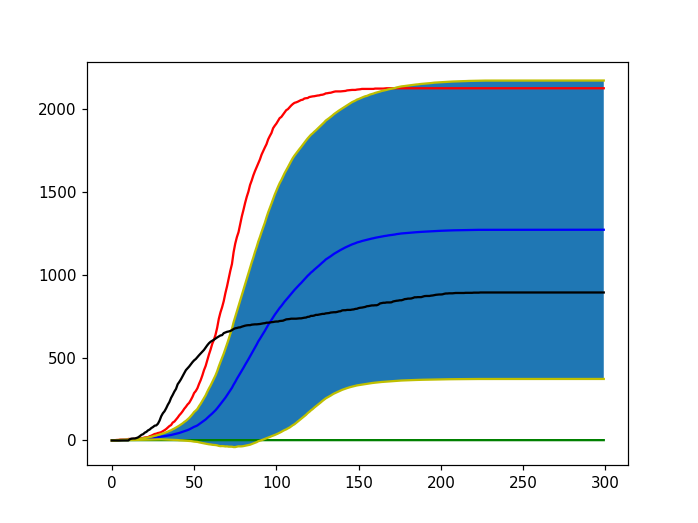

In [153]:
t = np.linspace(0, 299, 300)
plt.plot(t, maxCumInfNoBatch, 'r')
plt.plot(t, minCumInfNoBatch, 'g')
plt.plot(t, meanCumInfNoBatch, 'b')
plt.plot(t, meanCumInfNoBatch+sdCumInfNoBatch, 'y')
plt.plot(t, meanCumInfNoBatch-sdCumInfNoBatch, 'y')
plt.plot(t, UK2001Inf[:300], 'k')
plt.fill_between(t, meanCumInfNoBatch+sdCumInfNoBatch, meanCumInfNoBatch-sdCumInfNoBatch, 1)

In [83]:
np.savetxt('cumInfArray.csv',cumInfArray, delimiter=',')

<IPython.core.display.Javascript object>


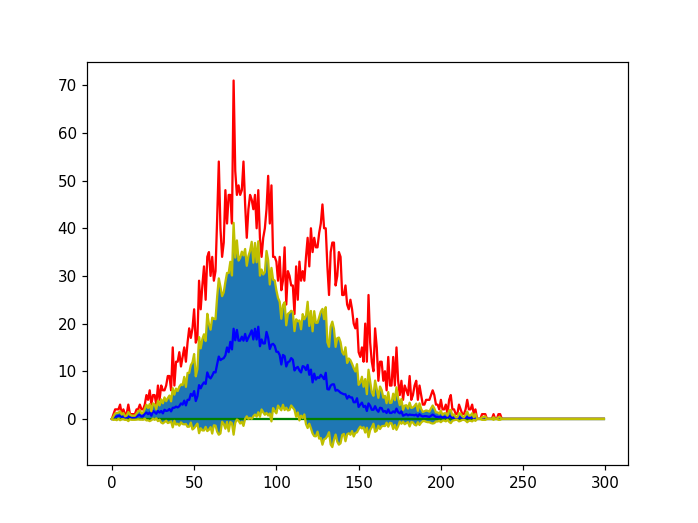

In [156]:
plt.figure()
t = np.linspace(0, 299, 300)
plt.plot(t, maxInfNoBatch, 'r')
plt.plot(t, minInfNoBatch, 'g')
plt.plot(t, meanInfNoBatch, 'b')
plt.plot(t, meanInfNoBatch+sdInfNoBatch, 'y')
plt.plot(t, meanInfNoBatch-sdInfNoBatch, 'y')
plt.fill_between(t, meanInfNoBatch+sdInfNoBatch, meanInfNoBatch-sdInfNoBatch, 1)

#No batch movement - 5km movement ban - 3km fixed cull - resource = 40

<IPython.core.display.Javascript object>


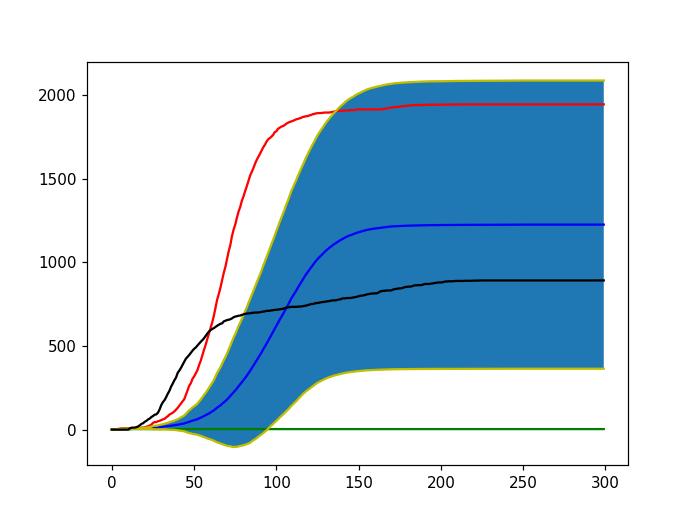

In [168]:
t = np.linspace(0, 299, 300)
plt.plot(t, maxCumInf5kmBan3kmCullFixed, 'r')
plt.plot(t, minCumInf5kmBan3kmCullFixed, 'g')
plt.plot(t, meanCumInf5kmBan3kmCullFixed, 'b')
plt.plot(t, meanCumInf5kmBan3kmCullFixed+sdCumInf5kmBan3kmCullFixed, 'y')
plt.plot(t, meanCumInf5kmBan3kmCullFixed-sdCumInf5kmBan3kmCullFixed, 'y')
plt.plot(t, UK2001Inf[:300], 'k')
plt.fill_between(t, meanCumInf5kmBan3kmCullFixed+sdCumInf5kmBan3kmCullFixed, meanCumInf5kmBan3kmCullFixed-sdCumInf5kmBan3kmCullFixed, 1)

<IPython.core.display.Javascript object>


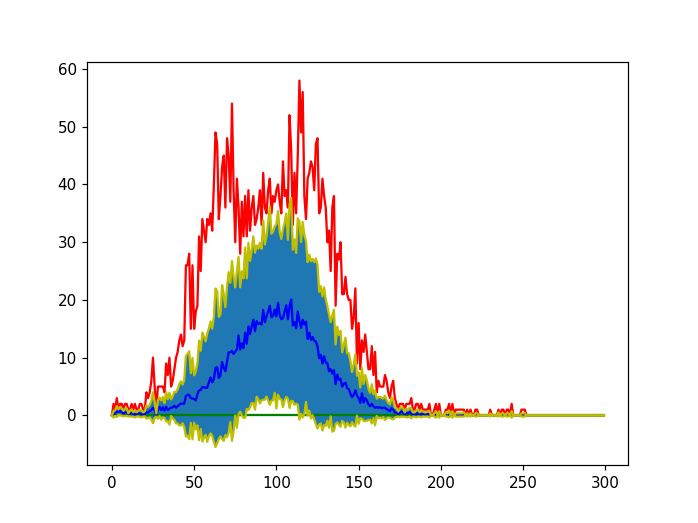

In [169]:
plt.figure()
t = np.linspace(0, 299, 300)
plt.plot(t, maxInf5kmBan3kmCullFixed, 'r')
plt.plot(t, minInf5kmBan3kmCullFixed, 'g')
plt.plot(t, meanInf5kmBan3kmCullFixed, 'b')
plt.plot(t, meanInf5kmBan3kmCullFixed+sdInf5kmBan3kmCullFixed, 'y')
plt.plot(t, meanInf5kmBan3kmCullFixed-sdInf5kmBan3kmCullFixed, 'y')
plt.fill_between(t, meanInf5kmBan3kmCullFixed+sdInf5kmBan3kmCullFixed, meanInf5kmBan3kmCullFixed-sdInf5kmBan3kmCullFixed, 1)

#Batch movement - 5km movement ban - 3km fixed cull - resource = 40

<IPython.core.display.Javascript object>


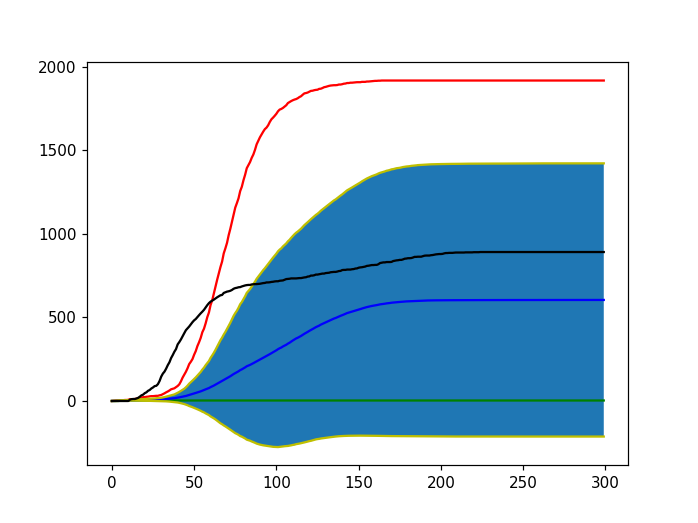

In [174]:
t = np.linspace(0, 299, 300)
plt.plot(t, maxCumInf5kmBan3kmCullFixedBatch, 'r')
plt.plot(t, minCumInf5kmBan3kmCullFixedBatch, 'g')
plt.plot(t, meanCumInf5kmBan3kmCullFixedBatch, 'b')
plt.plot(t, meanCumInf5kmBan3kmCullFixedBatch+sdCumInf5kmBan3kmCullFixedBatch, 'y')
plt.plot(t, meanCumInf5kmBan3kmCullFixedBatch-sdCumInf5kmBan3kmCullFixedBatch, 'y')
plt.plot(t, UK2001Inf[:300], 'k')
plt.fill_between(t, meanCumInf5kmBan3kmCullFixedBatch+sdCumInf5kmBan3kmCullFixedBatch, meanCumInf5kmBan3kmCullFixedBatch-sdCumInf5kmBan3kmCullFixedBatch, 1)

<IPython.core.display.Javascript object>


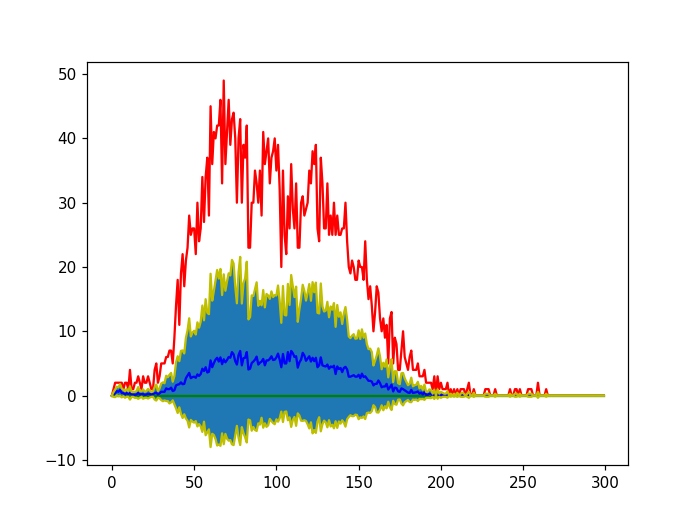

In [176]:
plt.figure()
t = np.linspace(0, 299, 300)
plt.plot(t, maxInf5kmBan3kmCullFixedBatch, 'r')
plt.plot(t, minInf5kmBan3kmCullFixedBatch, 'g')
plt.plot(t, meanInf5kmBan3kmCullFixedBatch, 'b')
plt.plot(t, meanInf5kmBan3kmCullFixedBatch+sdInf5kmBan3kmCullFixedBatch, 'y')
plt.plot(t, meanInf5kmBan3kmCullFixedBatch-sdInf5kmBan3kmCullFixedBatch, 'y')
plt.fill_between(t, meanInf5kmBan3kmCullFixedBatch+sdInf5kmBan3kmCullFixedBatch, meanInf5kmBan3kmCullFixedBatch-sdInf5kmBan3kmCullFixedBatch, 1)